In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

## Fashion MNIST

In [2]:
# defining transformation
transform = transforms.Compose([transforms.ToTensor()])

# load the training
full_train = datasets.FashionMNIST(root='../data', download=True, train=True, transform=transform)

In [3]:
full_loader = torch.utils.data.DataLoader(full_train, batch_size=32, shuffle=False)

## Calculating Mean and STD Dev for FashionMNIST

In [4]:
next(iter(full_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [5]:
mean = 0.
std = 0.
for images, _ in full_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1) # torch.Size([32, 1, 784])
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(full_loader.dataset)
std /= len(full_loader.dataset)

print('Mean:', mean)
print('Std:', std)

Mean: tensor([0.2860])
Std: tensor([0.3205])


## Transform with correct Mean and std_dev

In [6]:
# defining transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

# load the training and test data
trainset = datasets.FashionMNIST(root='../data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='../data', download=True, train=False, transform=transform)

In [7]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)
valid_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

## Visualizing Dataset

Class name: Ankle boot


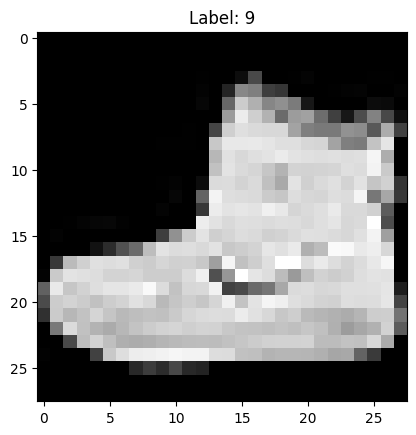

In [9]:
images, labels = next(iter(train_loader))
idx = 0
image = images[idx]
class_name = class_names[labels[idx].item()]
print(f'Class name: {class_name}')
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title(f'Label: {labels[idx].item()}')
plt.show()

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
	torch.cuda.manual_seed(42)
else:
	torch.manual_seed(42)
    
print(device)

cuda


## Stacked Autoencoder

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 30)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(30, 100)
        self.fc2 = nn.Linear(100, 28 * 28)
        self.reshape = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        x = self.reshape(x)
        return x

class StackedAutoEncoder(nn.Module):
    def __init__(self):
        super(StackedAutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x, y = None):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Model Initialization

In [95]:
del stacked_ae

In [96]:
stacked_ae = StackedAutoEncoder().to(device=device)
total_params = sum(p.numel() for p in stacked_ae.parameters())
trainable_params = sum(p.numel() for p in stacked_ae.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')
print(f'Non-trainable parameters: {non_trainable_params}')

Total parameters: 163814
Trainable parameters: 163814
Non-trainable parameters: 0


## Model Summary

In [97]:
import torchsummary

In [98]:
torchsummary.summary(stacked_ae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                   [-1, 30]           3,030
           Encoder-3                   [-1, 30]               0
            Linear-4                  [-1, 100]           3,100
            Linear-5                  [-1, 784]          79,184
         Unflatten-6            [-1, 1, 28, 28]               0
           Decoder-7            [-1, 1, 28, 28]               0
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.62
Estimated Total Size (MB): 0.65
----------------------------------------------------------------


In [99]:
for name, param in stacked_ae.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")

encoder.fc1.weight: 78400 parameters
encoder.fc1.bias: 100 parameters
encoder.fc2.weight: 3000 parameters
encoder.fc2.bias: 30 parameters
decoder.fc1.weight: 3000 parameters
decoder.fc1.bias: 100 parameters
decoder.fc2.weight: 78400 parameters
decoder.fc2.bias: 784 parameters


## Loss, Optimizer

In [100]:
criterion = nn.MSELoss()
optimizer = torch.optim.NAdam(stacked_ae.parameters(), lr = 0.001)

## Find good initial Learning Rate

### 1. Using lr range

In [101]:
def find_init_lr(model, criterion, optimizer, device, train_loader, num_iterations=1000):
    lre = torch.linspace(-4, -1, num_iterations).to(device)  # 10**-4 = 0.0001, 10**-1 = 0.1
    lrs = 10**lre.cpu()

    plt.plot(lrs, lre.cpu())
    plt.show()

    lre_i = []  # lre for i_th iter
    lrs_i = []  # lrs for i_th iter
    loss_i = []  # loss for i_th iter
    model.train()

    data_iter = iter(train_loader)

    print("\nOverfitting on dataset to check training stability and learning rate...")

    for i in range(num_iterations):
        try:
            data, _ = next(data_iter)
        except StopIteration:
            data_iter = iter(train_loader)
            data, _ = next(data_iter)

        data = data.to(device)
        targets = data.clone().to(device)
        
        ## Dynamic LR
        lr = lrs[i].item()
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
            
        
        # Zero grad
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, targets)

        # Optimization
        loss.backward()
        optimizer.step()


        lre_i.append(lre[i].item())
        lrs_i.append(lrs[i].item())
        loss_i.append(loss.item())
        if (i + 1) % 100 == 0:
            print(f'Iteration {i+1}/{num_iterations}, Loss: {loss.item():.6f}')
    return lre_i, lrs_i, loss_i

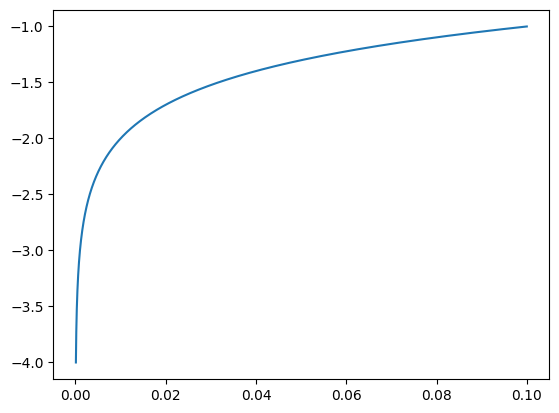


Overfitting on dataset to check training stability and learning rate...
Iteration 100/1000, Loss: 0.600494
Iteration 200/1000, Loss: 0.355885
Iteration 300/1000, Loss: 0.301310
Iteration 400/1000, Loss: 0.287460
Iteration 500/1000, Loss: 0.274312
Iteration 600/1000, Loss: 0.303895
Iteration 700/1000, Loss: 0.516635
Iteration 800/1000, Loss: 42.833237
Iteration 900/1000, Loss: 1.682601
Iteration 1000/1000, Loss: 1.542229


In [102]:
lre_i, lrs_i, loss_i = find_init_lr(stacked_ae, criterion, optimizer, device, train_loader)

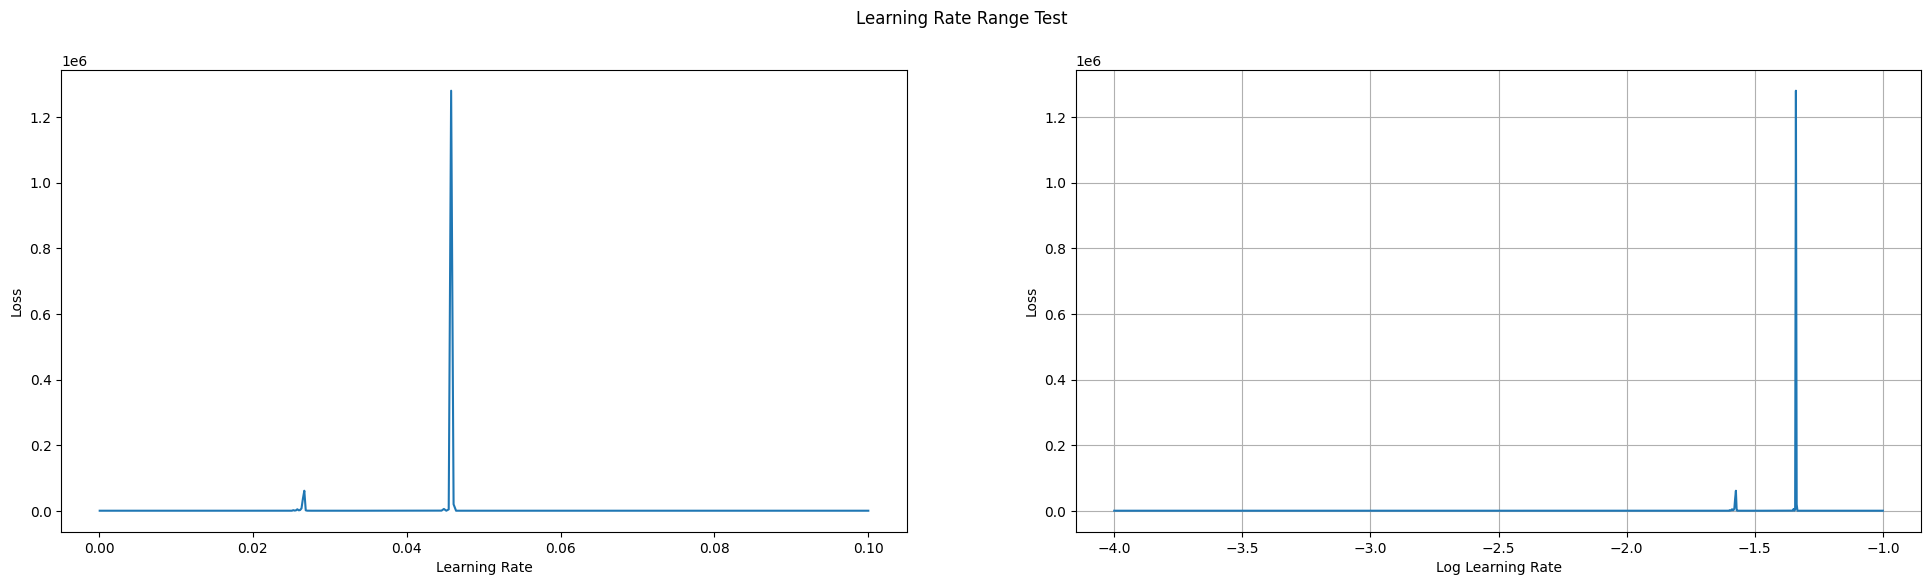

In [104]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(lrs_i, loss_i)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(lre_i, loss_i)
plt.xlabel('Log Learning Rate')
plt.ylabel('Loss')
plt.suptitle('Learning Rate Range Test')
plt.grid(True)
plt.show()

we can use lr of 0.05 to 0.2 (picked = 0.05)

### 2. Using `torch_lr_finder`  to Find a Good Learning Rate

In [17]:
from torch_lr_finder import LRFinder #!pip install torch-lr-finder

In [18]:
del stacked_ae
stacked_ae = StackedAutoEncoder().to(device=device)

In [19]:
from torch.utils.data import Dataset

class AutoencoderDataset(Dataset):
    """
    A wrapper that takes a base Dataset returning (x, label)
    and instead returns (x, x) LRFinder that expects (input, target).
    """
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        # in case of autoencoder, target == x, so
        return x, x

train_lrfinder_dataset = AutoencoderDataset(trainset)
train_lrfinder_loader = torch.utils.data.DataLoader(
    train_lrfinder_dataset,
    batch_size = 32,
    shuffle=False
)

In [20]:
lr_finder = LRFinder(stacked_ae, optimizer, criterion, device=device)

In [21]:
lr_finder.range_test(
    train_lrfinder_loader,
    end_lr=1,      
    num_iter=1000,   
    step_mode="exp"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.09E-03


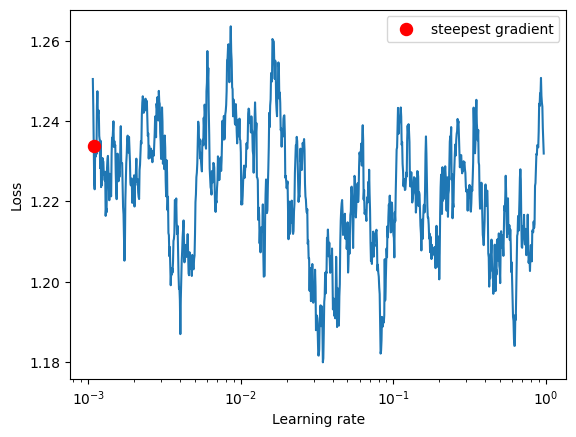

In [22]:
lr_finder.plot()
lr_finder.reset()

In [43]:
6.34E-02

0.0634

## Model Training

In [1]:
BATCH_SIZE = 32
num_epochs = 30

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.nn import functional as F


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
mean = (0.2860,)
std = (0.3205,)

In [5]:
# defining transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

# load the training and test data
trainset = datasets.FashionMNIST(root='../data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='../data', download=True, train=False, transform=transform)

# Use only the top 5000 samples from the training set
trainset = torch.utils.data.Subset(trainset, range(55000))
testset = torch.utils.data.Subset(trainset, range(5000, ))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 30)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(30, 100)
        self.fc2 = nn.Linear(100, 28 * 28)
        self.reshape = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        x = self.reshape(x)
        return x

class StackedAutoEncoder(nn.Module):
    def __init__(self):
        super(StackedAutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x, y = None):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
	torch.cuda.manual_seed(42)
else:
	torch.manual_seed(42)
    
print(device)

stacked_ae = StackedAutoEncoder().to(device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.NAdam(stacked_ae.parameters(), lr = 0.03)

cuda


In [8]:
# Train data stats
num_batches = len(train_loader)
total_data = len(train_loader.dataset)
# 5 * 32/60000 == 5 / 1875

# Turn on train mode
stacked_ae.train()
# train loss and val loss values
train_loss_per_epoch = []
valid_loss_per_epoch = []


for epoch in range(num_epochs):
    #============================TRAIN========================================
    train_loss = 0.0
    stacked_ae.train()
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    for batch, (imgs, y) in enumerate(train_bar):
        imgs = imgs.to(device)
        
        # Zero grad
        optimizer.zero_grad()
        
        # Forward Pass
        y_pred = stacked_ae(imgs)
        
        # Calculate loss
        loss = criterion(y_pred, imgs)
        
        # Optimization
        loss.backward()
        optimizer.step()
        
        # logging
        batch_loss = loss.item()
        train_loss += batch_loss
        
        #update progress (logging)
        train_bar.set_postfix({'Batch': f'{batch}/{num_batches}', 'Batch loss': f"{batch_loss:.5f}"})
        
    # Calculate average loss over epoch (train_set)
    avg_train_loss = train_loss / num_batches
    train_loss_per_epoch.append(avg_train_loss)
    
    #=============================EVAL=======================================
    stacked_ae.eval()
    val_loss = 0.0
    with torch.no_grad():
        valid_bar = tqdm(valid_loader, desc='Validation', leave = False)
        for (imgs, y) in valid_bar:
            imgs = imgs.to(device)
            # Forward Pass
            y_pred = stacked_ae(imgs)
            
            # Calculate loss
            loss = criterion(y_pred, imgs)
            
            #logging
            val_loss += loss.item() * imgs.size(0)

    # Calculate average loss for val dataset
    avg_val_loss = val_loss / len(valid_loader.dataset) # Explained: # 5 * 32/60000 == 5 / 1875
    valid_loss_per_epoch.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_val_loss:.4f}')
    

Epoch 1/30:   0%|          | 0/1719 [00:00<?, ?it/s]

Epoch 1/30:  79%|███████▉  | 1362/1719 [00:47<00:12, 28.95it/s, Batch=1361/1719, Batch loss=0.79745]


KeyboardInterrupt: 